In [1]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from evaluate.lane import LaneEval
import random
import os
%matplotlib inline


In [2]:
def show_samples(n_samples, images, randomize=False):
    """Shows multiple images from path list"""
    for sample_n in range(n_samples):
        if randomize:
            n = random.randint(0, len(images)-1)
        else:
            n = sample_n
        path = os.path.dirname(images[n])
        label = os.path.basename(path)
        #label = images[n][-32:-6]
        fig = plt.figure(figsize=(30,6))
        ax = plt.subplot(np.ceil(n_samples/3), 3, sample_n+1)
        ax.set_title(label)
        img = plt.imread(images[n])
        ax.imshow(img)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.tight_layout()
    plt.show()


### Get Data And Create small subset for testing

In [3]:
small_set = False
### READ FILE
data_path = "train_set/"
json_gt = [json.loads(line) for line in open('all_data.json')]
if small_set:
    subset = np.random.choice(json_gt, size=100, replace = False)
    json_gt=subset

def _get_gt(json_list, index):
    """Reads data from json"""
    gt = json_list[index]
    gt_lanes = gt['lanes']
    y_samples = gt['h_samples']
    raw_file = gt['raw_file']
    return [raw_file, gt_lanes, y_samples]

### Examine Data

Total data:  3626
Path example:  clips/0313-1/23700/20.jpg
Lane example:  [[-2, 570, 554, 538, 522, 505, 489, 473, 456, 440, 424, 407, 391, 375, 359, 342, 326, 310, 293, 277, 261, 244, 228, 212, 196, 179, 163, 147, 130, 114, 98, 81, 65, 49, 33, 16, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], [-2, -2, 601, 606, 611, 616, 621, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 684, 689, 694, 699, 704, 709, 714, 719, 724, 729, 734, 738, 743, 748, 753, 758, 763, 768, 773, 778, 783, 788, 793, 797, 802, 807, 812, 817, 822], [-2, -2, 516, 482, 449, 415, 382, 348, 314, 281, 247, 214, 180, 147, 113, 80, 46, 13, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], [-2, -2, 647, 673, 698, 724, 750, 775, 801, 826, 852, 877, 903, 928, 954, 980, 1005, 1031, 1056, 1082, 1107, 1133, 1158, 1184, 1210, 1235, 1261, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2]]


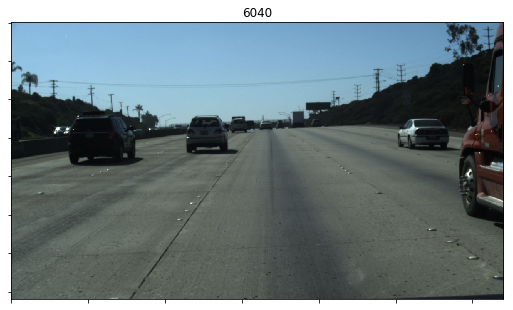

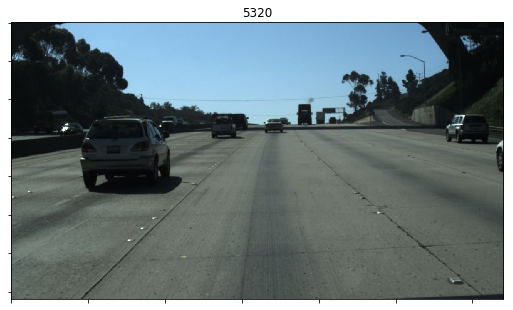

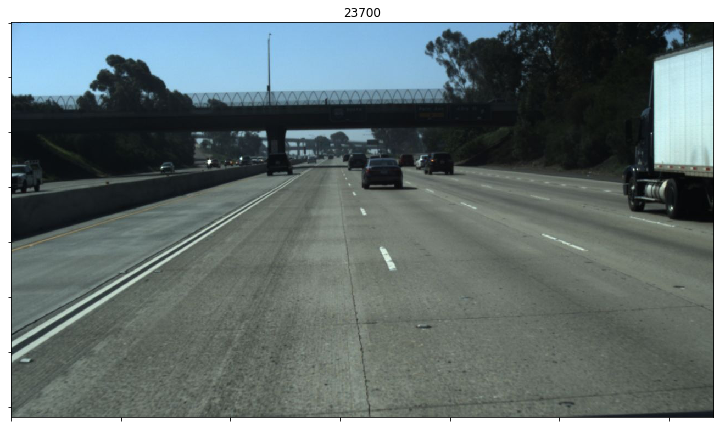

In [4]:
from sys import getsizeof
print("Total data: ",len(json_gt))
example_data = _get_gt(json_gt,2)
print("Path example: ", example_data[0])
print("Lane example: ", example_data[1])
example_img=[]
for i in range(3):
    example_data=_get_gt(json_gt, i)
    example_img.append("train_set/"+ example_data[0])
show_samples(3, example_img)

### Preprocessing

In [5]:
### Crop, as max index for evaluation is 160, no case
##  in looking above
def roi(img,y):
    """Region of Interest"""
    return(img[y:len(img)])

def draw_lanes(img, gt_lanes, y_samples, thickness=25):
    """raws lines from GT data"""
    gt_lanes_vis = [[(x, y) for (x, y) in zip(lane, y_samples) if x >= 0] for lane in gt_lanes]
    img_vis = np.zeros_like(img)
    if len(gt_lanes_vis)>4:
        gt_lanes_vis = gt_lanes_vis[0:4]
    for lane in gt_lanes_vis:
        lower =[]
        midd =[]
        upper=[]
        for x,y in lane:
            if y < 150+190:
                upper.append([x,y])
            if y >130+190 and y < 150+2*190:
                midd.append([x,y])
            if y > 130 +190*2:
                lower.append([x,y])
        cv2.polylines(img_vis, np.int32([upper]), isClosed=False, color=(0,255,0), thickness= thickness)
        cv2.polylines(img_vis, np.int32([midd]), isClosed=False, color=(0,255,0), thickness= thickness+10)
        cv2.polylines(img_vis, np.int32([lower]), isClosed=False, color=(0,255,0), thickness= thickness+20)
        
    return img_vis

def poly_to_points(poly):
    """Takes a second degree polynomial, returns x_coeffs at y_samples"""
    x=[]
    y=[]
    for y_test in range(160,720,10):
        y.append(y_test)
        pred = y*y*poly[0] + y*poly[1] + poly[2]
        if pred >0 and pred <1280:
            x.append(pred)
        else:
            x.append(-2)
    return x, y

def poly_to_line(img, poly):
    """Draws polynomial to image"""
    line=[]
    for y in range(180,730,10):
        x = y*y*poly[0] + y*poly[1] + poly[2]
        if x>0 and x<1280:
            line.append([np.int32(x), np.int32(y)])
    pts = np.asarray(line, np.int32)
    pts.reshape((-1,1,2))
    output=cv2.polylines(img, [pts], False, (255,0,0), 3)
    return output

def _filter_4lines(poly):
    """Takes polynomial coefficients, if not 4, return only 4
    """
    size=len(poly)
    if size <4:
        for i in range(4-size):
            poly.append(np.asarray([0,0,0]))
    return poly

def _get_coeffs(gt_lanes, y_samples):
    """Returns order 2 polynomials from ground truth points"""
    polys=[]
    gt_lanes_pts = [[(x, y) for (x, y) in zip(lane, y_samples) if x >= 0] for lane in gt_lanes]
    for lane in gt_lanes_pts:
        if len(lane)==0:
            polys.append(np.asarray([0,0,0]))
        else:
            lane = np.asarray(lane)
            x = lane[:,0]
            y = lane[:,1]
            polys.append(np.polyfit(y,x, 2))
    polys = _filter_4lines(polys)
    return polys
    
def _toBinaryThresh(S_channel, low_limit=0, high_limit=255):
    """Takes saturation channel, outputs binary image"""
    s_binary=np.zeros_like(S_channel)
    s_binary[(S_channel>=low_limit) & (S_channel<=high_limit)]=1
    return s_binary

def generate_GT(data, input_path="train_set/", debbug=False, output_dir="out_img/generate_GT/", save_big_mask= False):
    """Takes data read from GT json, ouputs polynomials, GT_mask and image"""
    path = os.path.dirname(data[0])
    name = os.path.basename(path)
    img = mpimg.imread(input_path +data[0])
    poly_lanes=_get_coeffs(data[1], data[2])
    
    mask=draw_lanes(img, test_data[1], test_data[2],5)
    binary_mask=_toBinaryThresh(mask[:,:,1], 200,255)
    
    hsv_img= cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv_img[:,:,2]
    v_channel = _toBinaryThresh(v_channel, 170,255)
    
    h_channel = hsv_img[:,:,0]
    h_channel = _toBinaryThresh(h_channel, 15,25)
    
    gt_patch = cv2.bitwise_or(h_channel, v_channel)
    gt_patch=cv2.bitwise_and(gt_patch, binary_mask)
    
    kernel= np.ones((3,3))
    gt_patch = cv2.morphologyEx(gt_patch,cv2.MORPH_CLOSE, kernel)
    kernel= np.ones((3,5))
    #gt_patch = cv2.dilate(gt_patch, kernel, iterations=1) 
    
    overlay=np.zeros_like(img)
    overlay[:,:,1] = 255*gt_patch
    
    if save_big_mask:
        #mpimg.imsave(GT_binary+"Overlay.jpg",overlay)
        print("save_big_mask not implemented!")
    
    if debbug:
        mpimg.imsave("out_img/" + name + ".jpg",img)
        mpimg.imsave("out_img/"+ name +"GT_lanes_.jpg",mask)
        regression = np.copy(img)
        for poly in poly_lanes:
            regression=poly_to_line(regression, poly)
        mpimg.imsave(output_dir + name +"poly_reversed_GT.jpg",regression)
        mpimg.imsave(output_dir+name+"_v_chan.jpg",v_channel)
        mpimg.imsave(output_dir+name+"_h_chan.jpg",h_channel)
        mpimg.imsave(output_dir+name+"patch.jpg",gt_patch)
        mpimg.imsave(output_dir+name+"Overlay.jpg",overlay)
        result = cv2.addWeighted(overlay,.4,img,.6,0)
        mpimg.imsave(output_dir+name+"Result.jpg",result)
        
    img = cv2.resize(img, None,fx=0.25, fy=0.25)
    overlay = cv2.resize(overlay, None,fx=0.25, fy=0.25)
    
    return name, poly_lanes, overlay, img
    


### Generate GT mask

Working on data:  0
Working on data:  180
Working on data:  360
Working on data:  540
Working on data:  720
Working on data:  900


C:\Users\Doctor\.conda\envs\vision-env\lib\site-packages\ipykernel_launcher.py:75: RankWarning: Polyfit may be poorly conditioned


Working on data:  1080
Working on data:  1260


C:\Users\Doctor\.conda\envs\vision-env\lib\site-packages\ipykernel_launcher.py:75: RankWarning: Polyfit may be poorly conditioned


Working on data:  1440
Working on data:  1620
Working on data:  1800


C:\Users\Doctor\.conda\envs\vision-env\lib\site-packages\ipykernel_launcher.py:75: RankWarning: Polyfit may be poorly conditioned


Working on data:  1980
Working on data:  2160
Working on data:  2340


C:\Users\Doctor\.conda\envs\vision-env\lib\site-packages\ipykernel_launcher.py:75: RankWarning: Polyfit may be poorly conditioned
C:\Users\Doctor\.conda\envs\vision-env\lib\site-packages\ipykernel_launcher.py:75: RankWarning: Polyfit may be poorly conditioned


Working on data:  2520
Working on data:  2700


C:\Users\Doctor\.conda\envs\vision-env\lib\site-packages\ipykernel_launcher.py:75: RankWarning: Polyfit may be poorly conditioned


Working on data:  2880


C:\Users\Doctor\.conda\envs\vision-env\lib\site-packages\ipykernel_launcher.py:75: RankWarning: Polyfit may be poorly conditioned


Working on data:  3060


C:\Users\Doctor\.conda\envs\vision-env\lib\site-packages\ipykernel_launcher.py:75: RankWarning: Polyfit may be poorly conditioned


Working on data:  3240


C:\Users\Doctor\.conda\envs\vision-env\lib\site-packages\ipykernel_launcher.py:75: RankWarning: Polyfit may be poorly conditioned
C:\Users\Doctor\.conda\envs\vision-env\lib\site-packages\ipykernel_launcher.py:75: RankWarning: Polyfit may be poorly conditioned


Working on data:  3420
Working on data:  3600
Dump Done!


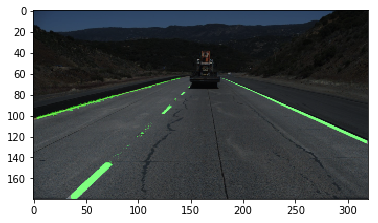

In [6]:
x=[]
y=[]
names=[]
polys=[]
rute=[]
for i in range(len(json_gt)):
    test_data = _get_gt(json_gt,i)
    name, poly, mask, img = generate_GT(test_data)
    names.append(name)
    rute.append(test_data[0])
    polys.append(poly)
    x.append(img)
    y.append(mask)
    if (i%180 == 0):
        print("Working on data: ", i)
    
    #mpimg.imsave("out_img/" + name + "_mask.jpg",mask)
    #mpimg.imsave("out_img/" + name + "_img.jpg",img)
   
plt.imshow(cv2.addWeighted(mask, 0.5, img, 0.5, 0))
print("Dump Done!")


23700
clips/0313-1/23700/20.jpg
[array([ -1.89264895e-06,  -1.62829813e+00,   9.77581240e+02]), array([  1.40162027e-07,   4.90971043e-01,   4.73300126e+02]), array([  6.12745098e-05,  -3.39531863e+00,   1.39461250e+03]), array([  1.00587865e-17,   2.55615385e+00,  -1.73384615e+01])]


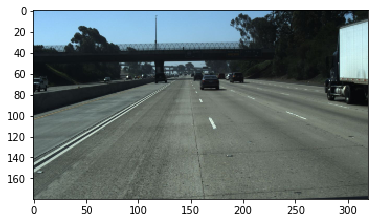

In [7]:
print(names[2])
print(rute[2])
print(polys[2])
plt.imshow(x[2])

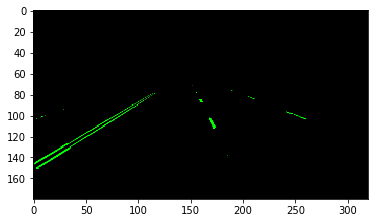

In [8]:
plt.imshow(y[2])

In [9]:
import pickle
data = {"Short_name": name, "path": rute, "Polynomials": polys, "Raw": x, "GroundTruth":y}
pickle.dump(data, open("Preprocessed_data.p", "wb"))

print("Data Saved!")

Data Saved!
